In [14]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import cv2

%matplotlib inline

In [15]:
faceDetectClassifier = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")

In [16]:
def normalize(X, low, high, dtype=None):
    X = np.asarray(X)
    minX, maxX = np.min(X), np.max(X)
    # normalize to [0...1].	
    X = X - float(minX)
    X = X / float((maxX - minX))
    # scale to [low...high].
    X = X * (high-low)
    X = X + low
    if dtype is None:
        return np.asarray(X)
    return np.asarray(X, dtype=dtype)

def read_images(path, sz=None):
    X,y = [], []
    
    for file_name in os.listdir(path):
        gray = cv2.imread(os.path.join(path,file_name),0)
        if len(gray):
            faces = faceDetectClassifier.detectMultiScale(gray, 1.2, 5)
            if len(faces):
                [x_i,y_i,w,h]  = faces[0]
                thing = gray[y_i: y_i + w, x_i: x_i + h]
                thing = cv2.resize(thing,(150,150))
                X.append(thing)

                labelRead = int(os.path.split(file_name)[1].split(".")[0].replace("subject", "")) - 1
                y.append(labelRead)
    
    return [X,y]

def asRowMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((0, X[0].size), dtype=X[0].dtype)
    for row in X:
        mat = np.vstack((mat, np.asarray(row).reshape(1,-1)))
    return mat

def asColumnMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((X[0].size, 0), dtype=X[0].dtype)
    for col in X:
        mat = np.hstack((mat, np.asarray(col).reshape(-1,1)))
    return mat

In [17]:
def pca(X, y, num_components=0):
    [n,d] = X.shape
    if (num_components <= 0) or (num_components>n):
        num_components = n
    mu = X.mean(axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
    # or simply perform an economy size decomposition
    # eigenvectors, eigenvalues, variance = np.linalg.svd(X.T, full_matrices=False)
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    # select only num_components
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:,0:num_components].copy()
    return [eigenvalues, eigenvectors, mu]


In [18]:
def project(W, X, mu=None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X - mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y,W.T)
    return np.dot(Y, W.T) + mu

In [19]:
def create_font(fontname='Tahoma', fontsize=10):
    return { 'fontname': fontname, 'fontsize':fontsize }

def subplot(title, images, rows, cols, sptitle="subplot", sptitles=[], colormap=cm.gray, ticks_visible=True, filename=None):
    fig = plt.figure()
    # main title
    fig.text(.5, .95, title, horizontalalignment='center') 
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows,cols,(i+1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)
        if len(sptitles) == len(images):
            plt.title("%s #%s" % (sptitle, str(sptitles[i])), create_font('Tahoma',10))
        else:
            plt.title("%s #%d" % (sptitle, (i+1)), create_font('Tahoma',10))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    if filename is None:
        plt.show()
    else:
        fig.savefig(filename)

def imsave(image, title="", filename=None):
    plt.figure()
    plt.imshow(np.asarray(image))
    plt.title(title, create_font('Tahoma',10))
    if filename is None:
        plt.show()
    else:
        fig.savefig(filename)

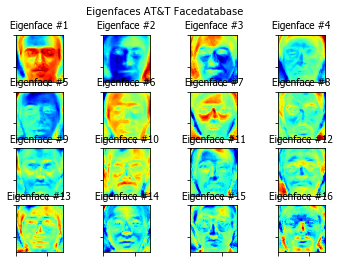

In [20]:
# read images
[X,y] = read_images("data/yalefaces")
# perform a full pca
[D, W, mu] = pca(asRowMatrix(X), y)

# turn the first (at most) 16 eigenvectors into grayscale
# images (note: eigenvectors are stored by column!)
E = []
for i in range(min(len(X), 16)):
    e = W[:,i].reshape(X[0].shape)
    E.append(normalize(e,0,255))
# plot them
subplot(title="Eigenfaces AT&T Facedatabase", images=E, rows=4, cols=4, sptitle="Eigenface", colormap=cm.jet)

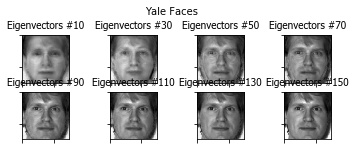

In [21]:
# reconstruction steps
steps=[i for i in range(10, min(len(X), 320), 20)]
E = []
for i in range(min(len(steps), 16)):
    numEvs = steps[i]
    P = project(W[:,0:numEvs], X[0].reshape(1,-1), mu)
    R = reconstruct(W[:,0:numEvs], P, mu)
    # reshape and append to plots
    R = R.reshape(X[0].shape)
    E.append(normalize(R,0,255))
# plot them
subplot(title="Yale Faces", images=E, rows=4, cols=4, sptitle="Eigenvectors", sptitles=steps, colormap=cm.gray)

In [22]:
class AbstractDistance(object):
    def __init__(self, name):
        self._name = name

    def __call__(self,p,q):
        raise NotImplementedError("Every AbstractDistance must implement the __call__ method.")

    @property
    def name(self):
        return self._name

    def __repr__(self):
        return self._name

class EuclideanDistance(AbstractDistance):

    def __init__(self):
        AbstractDistance.__init__(self,"EuclideanDistance")

    def __call__(self, p, q):
        p = np.asarray(p).flatten()
        q = np.asarray(q).flatten()
        return np.sqrt(np.sum(np.power((p-q),2)))

class CosineDistance(AbstractDistance):

    def __init__(self):
        AbstractDistance.__init__(self,"CosineDistance")

    def __call__(self, p, q):
        p = np.asarray(p).flatten()
        q = np.asarray(q).flatten()
        return -np.dot(p.T,q) / (np.sqrt(np.dot(p,p.T)*np.dot(q,q.T)))

In [23]:
class BaseModel(object):
    def __init__(self, X=None, y=None, dist_metric=EuclideanDistance(), num_components=0):
        self.dist_metric = dist_metric
        self.num_components = 0
        self.projections = []
        self.W = []
        self.mu = []
        if (X is not None) and (y is not None):
            self.compute(X,y)

    def predict(self, X):
        minDist = np.finfo('float').max
        minClass = -1
        Q = project(self.W, X.reshape(1,-1), self.mu)
        for i in range(len(self.projections)):
            dist = self.dist_metric(self.projections[i], Q)
            if dist < minDist:
                minDist = dist
                minClass = self.y[i]
        return minClass

class EigenfacesModel(BaseModel):

    def __init__(self, X=None, y=None, dist_metric=EuclideanDistance(), num_components=0):
        super(EigenfacesModel, self).__init__(X=X,y=y,dist_metric=dist_metric,num_components=num_components)

    def compute(self, X, y):
        [D, self.W, self.mu] = pca(asRowMatrix(X),y, self.num_components)
        # store labels
        self.y = y
        # store projections
        for xi in X:
            self.projections.append(project(self.W, xi.reshape(1,-1), self.mu))

In [24]:
[X,y] = read_images('data/yalefaces')
# compute the eigenfaces model
model = EigenfacesModel(X[1:], y[1:])
# get a prediction for the first observation
print("expected =", y[0], "/", "predicted =", model.predict(X[0]))

expected = 0 / predicted = 0


## References
1. https://github.com/bytefish/facerecognition_guide